<a href="https://colab.research.google.com/github/Sandoval-G-98/SOA-AppJava/blob/feature%2FTP3-ejercicio-1/TP3/Ejercicio1/Ejecicio1_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 1 Introducción
Toma la direcciòn web de una imagen con  acceso público en internet, la deja disponible al contexto de ejecuciòn del cuaderno colab.

---
# 2 Armado del ambiente

In [5]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg


#@markdown ### Especifique el Blur que se desea realizar (numero entero):
#@markdown ###### Numeros mayores a 10 tardaran más de 10 minutos
blurfactor = 1 #@param {type:"integer"}



--2021-11-23 05:09:17--  https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg [following]
--2021-11-23 05:09:18--  https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg [following]
--2021-11-23 05:09:18--  https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147032 (144K) [image/j

---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [2]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 66 kB 4.1 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627448 sha256=04a2f3f305b237ac8b0dfeb4da9c256d5e8085285bbf49c535cc794eb3d0ab64
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=fe6694523b5eb602367b7057c13d90504bd8025ce7362dfdbf26d447ef9b93c9
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


---
# 3 Desarrollo CPU

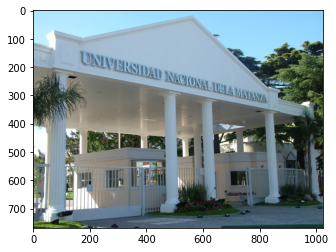

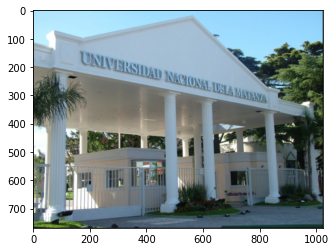

In [8]:
%matplotlib inline
from datetime import datetime

tiempo_total_cpu = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 
from matplotlib.image import imread

global tiempo_blur_cpu, tiempo_total_cpu

def average(img, x, y, blurfactor):
  rtotal = gtotal = btotal = 0
  for x2 in range(x-blurfactor, x+blurfactor+1):
    for y2 in range(y-blurfactor, y+blurfactor+1):
      r, g, b = img.getpixel((x2, y2))
      rtotal = rtotal + r
      gtotal = gtotal + g
      btotal = btotal + b
  rtotal = rtotal // ((blurfactor * 2 + 1)**2)
  gtotal = gtotal // ((blurfactor * 2 + 1)**2)
  btotal = btotal // ((blurfactor * 2 + 1)**2)
  return (rtotal, gtotal, btotal)


# Abro la imagen
img_nombre = 'imagen.jpg'
image = Image.open( img_nombre )
# Optengo las proporsiones de la imagen. 
img_ancho, img_alto = image.size 

newImg = Image.new("RGB", (img_ancho, img_alto), (0, 0, 0))
#blurfactor = 5

tiempo_blur_cpu = datetime.now()

for x in range(blurfactor, img_ancho - blurfactor):
  for y in range(blurfactor, img_alto - blurfactor):
    r, g, b = image.getpixel((x,y))
    r2, g2, b2, = average(image, x, y, blurfactor)
    newImg.putpixel((x,y), (r2, g2, b2))

tiempo_blur_cpu = datetime.now() - tiempo_blur_cpu

plt.figure()
imgplot=plt.imshow( image )
plt.figure()
imgplot=plt.imshow( newImg )

tiempo_total_cpu = datetime.now() - tiempo_total_cpu



---
# 4 Desarrollo GPU

Imagen del filtro: pepe.jpeg -RGB- [515, 491]
Thread: [ 16 , 19  ], Bloque : [ 33 , 26 ]
Total de Thread: [ 528 , 494  ]  =  260832


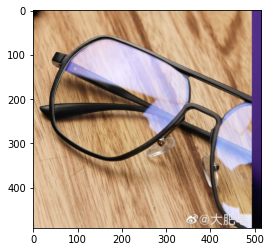

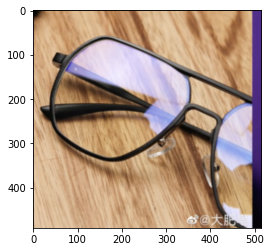

In [6]:
%matplotlib inline
from datetime import datetime
tiempo_total_gpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

global tiempo_blur_gpu, tiempo_total_gpu

img_nombre = 'pepe.jpeg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like(img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int blurfactor, int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  int pxl = (idx+(idy*ancho))*3;
  //int blurfactor = 1;
  float rtotal = 0.0;
  float gtotal = 0.0;
  float btotal = 0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el componente de cada color para cada pixel, en base al blur ingresado.
    for (int i = idx-blurfactor; i < idx+blurfactor+1; i++)
    {
      for (int j = idy-blurfactor; j < idy+blurfactor+1; j++)
      {
        pxl = (i+(j*ancho))*3;
        rtotal += img_O[pxl  ];  // Componente Rojo del pixel.
        gtotal += img_O[pxl+1];  // Componente Verde del pixel.
        btotal += img_O[pxl+2];   // Componente Azul del pixel.
      }
    }

    double aux = (pow((blurfactor * 2 + 1), 2));

    // Escribo el color del pixel.
    img_R[pxl  ] = rtotal / aux;
    img_R[pxl+1] = gtotal / aux;
    img_R[pxl+2] = btotal / aux;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_blur_gpu = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_blur_gpu = datetime.now()

kernel( numpy.int32(blurfactor), numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1))

tiempo_blur_gpu = datetime.now() - tiempo_blur_gpu

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total_gpu = datetime.now() - tiempo_total_gpu

---
# 5 Métricas

In [11]:
# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

print( "\nCPU:")
print( "Tiempo de blur:", tiempo_en_ms( tiempo_blur_cpu   ), "[ms]" )
print( "Tiempo total  :", tiempo_en_ms( tiempo_total_cpu ), "[ms]" )

print( "\nGPU:")
print( "Tiempo de blur:", tiempo_en_ms( tiempo_blur_gpu   ), "[ms]" )
print( "Tiempo total  :", tiempo_en_ms( tiempo_total_gpu ), "[ms]" )

print( "\nMejora de GPU vs CPU:")
print( "Tiempo de blur: -", tiempo_en_ms( tiempo_blur_cpu - tiempo_blur_gpu   ), "[ms]" )
print( "Tiempo total  : -", tiempo_en_ms( tiempo_total_cpu - tiempo_total_gpu ), "[ms]" )


CPU:
Tiempo de blur: 14157.057 [ms]
Tiempo total  : 14274.414 [ms]

GPU:
Tiempo de blur: 2.164 [ms]
Tiempo total  : 78.477 [ms]

Mejora de GPU vs CPU:
Tiempo de blur: - 14154.893 [ms]
Tiempo total  : - 14195.937 [ms]


---
# 6 Conclusiones

Se puede observar una clara mejora en el tiempo de ejecución en la version de GPU. La misma es de tal magnitud ya que se ejecuta el filtro de manera paralela, en contrapartida con su version en CPU, la cual es de manera secuencial.

---
# 7 Bibliografia

<>ingesar bibliografia>

---

---

---


# Respuesta al cuestionario:

1. Explicar detalladamente como utilizar el ejercicio (Tips: manual de usuario).
2. Deben indicar la dirección web del ejercicio dentro del repositorio GitHub.
3. Explicar cómo funciona el ejercicio desde el punto de vista de la programación CPUGPU.
4. Debe experimentar respondiendo a las consignas:

  A. ¿Qué sucede si se planifican la mitad de los hilos-gpu?
  
  B. ¿Qué sucede si se planifican el doble de hilos-gpu?
  
  C. ¿Qué cambios hay que hacer para procesar la mitad inicial de la imagen origen?
  
  D. ¿Qué cambios hay que hacer para procesar la mitad final de la imagen destino?
  
  E. ¿Cuál es el resultado si se utilizan un tamaño de bloques igual a la cantidad máxima de hilos soportada por el GPGPU?

